# Machine Learning Assignment #1 - Image Classification

### 0. Fill the blanks to train and test image classification model:
- Data Augmentation with custom transformation (clipping, flipping, ...)
- Configuration of the model
- Loss function for training the model

In [1]:
import torch
random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('current device: ',device)

current device:  cuda


## 1. Prepare the dataset

In [2]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
import matplotlib.pyplot as plt # for visualization 
%matplotlib inline  

import numpy as np
import math 
from PIL import Image

### 1-1. Augment the data
- Fill in the blanks (RandomVerticalFlip, RandomHorizontalFlip, Rotation)

In [3]:
def convert2numpy(image):
    if torch.is_tensor(image):
        image = image.data.cpu().numpy()
    else:
        image = np.array(image)
    return image

class RandomCrop(object):
    def __init__(self, crop_pixel:int = 5):
        self.crop_pixel = crop_pixel

    def __call__(self, image):
        image = convert2numpy(image)
        # Image: Height x Width x Channel
        x_y = np.random.choice(image.shape[0] - self.crop_pixel, 2)
        start_x, start_y = x_y[0], x_y[1]
        image[start_x: start_x + self.crop_pixel, start_y: start_y + self.crop_pixel, :] = 0.0

        return image

class RandomVerticalFlip(object):
    # Based on the execution probability flip image vertically
    # FILL BLANK 1
        # Define self.execute (bool). determines whether to apply the augmentation to each image based on the probability of being executed.
        # Flip the image vertically based on the probability of it being flipped
    def __init__(self, probability = 0.7):
        assert probability >= 0.0 and probability <= 1.0
        self.sampling_size = 100
        self.probability = probability

    def __call__(self, image):
        self.execute = np.random.rand() < self.probability # 실행 경계값 0.5로 설정

        if self.execute:
            new_image = np.flipud(image)
            return np.copy(new_image) # negative stride 방지를 위해서 copy
        else:
            return image

class RandomHorizontalFlip(object):
    # Flip based on the probability.
    # FILL BLANK 2
        # Define self.execute (bool). determines whether to apply the augmentation to each image based on the probability of being executed.
        # Flip the image horizontally based on the probability of it being flipped
    def __init__(self, probability = 0.7):
        assert probability >= 0.0 and probability <= 1.0
        self.sampling_size = 100
        self.probability = probability

    def __call__(self, image):
        self.execute = np.random.rand() < self.probability  # 경계값 0.5로 설정

        if self.execute:
            new_image = np.fliplr(image)
            return np.copy(new_image) # negative stride 방지를 위해서 copy
        else:
            return image

class Rotation(object):
    # Details about Rotation matrix: https://en.wikipedia.org/wiki/Rotation_matrix#In_three_dimensions
    # FILL BLANK 3
        # Fill in the blanks
    def __init__(self, angle_of_rotation:float = 10):
        self.angle_range = angle_of_rotation

    def __call__(self, image):
        random_angle = np.random.choice(self.angle_range)
        image = convert2numpy(image)
        angle=math.radians(random_angle)                   #converting degrees to radians
        cosine=math.cos(angle)
        sine=math.sin(angle)
        height=image.shape[0]                                   #define the height of the image
        width=image.shape[1]                                    #define the width of the image

        # Define the height and width of the new image that is to be formed
        new_height  = round(abs(image.shape[0]*cosine)+abs(image.shape[1]*sine))+1
        new_width  = round(abs(image.shape[1]*cosine)+abs(image.shape[0]*sine))+1

        # define another image variable of dimensions of new_height and new _column filled with zeros
        output=np.zeros((new_height,new_width,image.shape[2]))

        # Find the centre of the image about which we have to rotate the image
        original_centre_height   = round(((image.shape[0]+1)/2)-1)    #with respect to the original image
        original_centre_width    = round(((image.shape[1]+1)/2)-1)    #with respect to the original image

        # Find the centre of the new image that will be obtained
        new_centre_height= round(((new_height+1)/2)-1)        #with respect to the new image
        new_centre_width= round(((new_width+1)/2)-1)          #with respect to the new image

        for i in range(height):
            for j in range(width):
                #co-ordinates of pixel with respect to the centre of original image
                y = image.shape[0]-1-i-original_centre_height
                x = image.shape[1]-1-j-original_centre_width

                #co-ordinate of pixel with respect to the rotated image
                new_y = round(-x *sine + y * cosine)
                new_x = round(x * cosine + y * sine)

                '''since image will be rotated, the centre will change too,
                so to adust to that we will need to change new_x and new_y with respect to the new centre'''
                new_y = new_centre_height - new_y
                new_x = new_centre_width - new_x

                # adding if check to prevent any errors in the processing
                if 0 <= new_x < new_width and 0 <= new_y < new_height and new_x>=0 and new_y>=0:
                    output[new_y,new_x]=image[i,j]

        return Image.fromarray((output).astype(np.uint8))

def imshow(img):
    # Un-normalize and display the image
    img = img / 2 + 0.5
    plt.imshow(np.transpose(img, (1,2,0)))

### 1-2. Apply the augmentation to the dataset.
- Please do not add other augmentation to the test dataset.

In [4]:
# Note:
    # For visualization, 
        # use torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    # For training and testing the model, 
        # use torchvision.transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))

train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.CIFAR10('./', train=True, download=True,
        transform=torchvision.transforms.Compose([
        RandomCrop(),
        Rotation(),
        RandomHorizontalFlip(),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Resize(32),
        #torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        torchvision.transforms.Normalize((0.4914, 0.4822, 0.4465), 
                                        (0.247, 0.243, 0.261))
        ])),
    batch_size=128, shuffle=True, num_workers=0)

test_loader = torch.utils.data.DataLoader(
        torchvision.datasets.CIFAR10('./', train=False, download=True,
        transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Resize(32),
        #torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        torchvision.transforms.Normalize((0.4914, 0.4822, 0.4465), 
                                       (0.247, 0.243, 0.261))
        ])),
    batch_size=128, shuffle=False, num_workers=0)

# './': location of dataset to be downloaded
# train: (True or False): get dataset for training (or testing)
# download (True or False) will automatrically download the dataset
# To do: Make custom data transform

Files already downloaded and verified
Files already downloaded and verified


### 1-3. Plot the augmented images.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

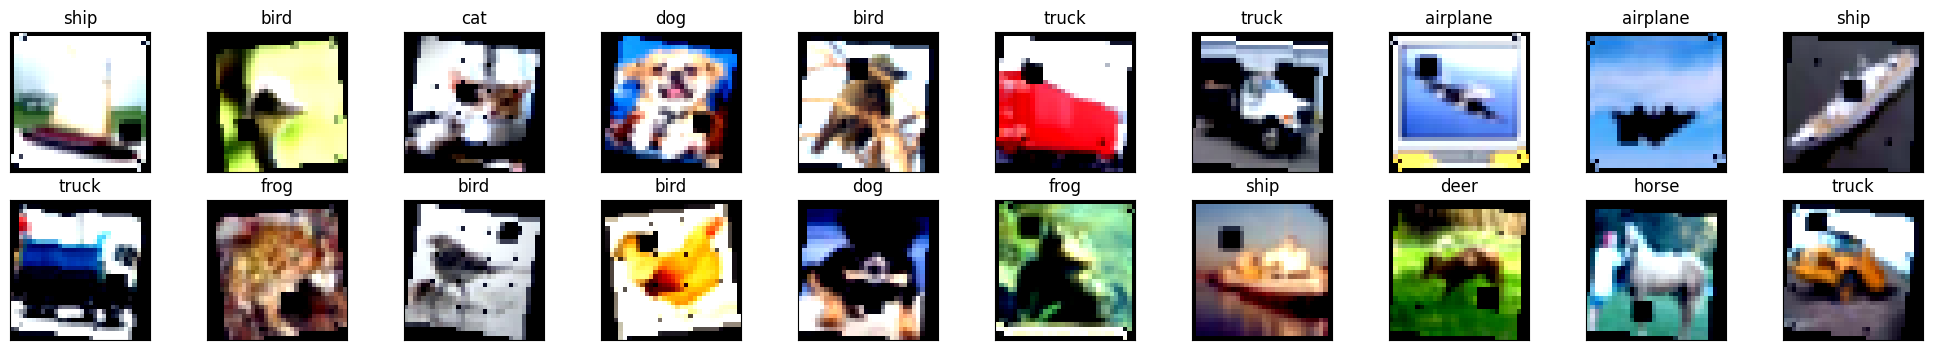

In [5]:
# Get one batch of training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
# Convert images to numpy for display
images = images.numpy()

classes = ["airplane", "automobile", "bird", "cat", "deer", 
           "dog", "frog", "horse", "ship", "truck"]

# Plot the images in the batch
fig = plt.figure(figsize=(25, 4))

# Display 20 images
# Viaulize Images
for idx in np.arange(20):
    ax = fig.add_subplot(2, int(20/2), idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

### 2. Prepare the model; ResNet
### 2-1. Define the block of the ResNet

In [6]:
class BasicBlock(nn.Module):
    expansion = 1
    # Make the Basic Block of ResNet
    # FILL BLANK 4
        # (Hint) torch.nn.Conv2d('something'), 
        # torch.nn.BatchNorm2d('something'), 
        # Need to fill in the configuration of Conv2d and BatchNorm2d function
    def __init__(self, in_planes, planes, stride=1):    
        # in_planes:int: input channels
        # planes:int: output channels
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes) # output plane 정규화

        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)    # Fill in
        self.bn2 = nn.BatchNorm2d(planes) # Fill in

        self.shortcut = nn.Sequential()
        if stride != 1:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes))

    def forward(self, x):
        # x: input images
        # FILL BLANK 5
        # Hint: F.relu(), self.conv2(), self.bn2(), self.shortcut()

        # ResNet 포워딩 과정
        # X -> conv1 layer -> normalize -> relu -> F(x) 
        # F(x) -> conv2 layer -> normalize -> relu -> F'(x)
        # F'(x) + shortcut(X)
        # F'(x) -> relu -> out.
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

### 2-2. Complete ResNet model

In [7]:
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1) 
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

def ResNet10():
    return ResNet(BasicBlock, [1, 1, 1, 1])

In [8]:
# Some code for saving and loading model.
# Use if you needed.
def save_model(model, save_name):
    path = './' + str(save_name) + '.pt'
    ckpt = {'model': model}
    torch.save(ckpt, path)

def load_model(init_model, load_name):
    path = './' + str(load_name) + '.pt'
    load_file = torch.load(path, map_location='cpu')
    model = load_file['model']
    init_model.load_state_dict(model.state_dict())
    return init_model

### 3. Code for training and testing.
### 3-1. Mannually implement cross entropy function

In [9]:
# 로그 파일 셋업
import logging
import os

# 로그 파일 저장 상위 디렉토리 생성
log_dir = './log'
if not os.path.exists(log_dir):
    os.makedirs(log_dir)

# log file 경로
train_log_file = f"{log_dir}/train.log"
test_log_file = f"{log_dir}/test.log"

class CustomLogger:
    def __init__(self, name):
        self.logger = logging.getLogger(name)
        self.logger.propagate = False
        self.formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
        self.logger.setLevel(logging.INFO)  # Set logger level

    def impl_file_handler(self, file_name):
        file_handler = logging.FileHandler(file_name)
        file_handler.setLevel(logging.INFO)
        file_handler.setFormatter(self.formatter)
        self.logger.addHandler(file_handler)

    def write_log(self, message):
        self.logger.info(message)

    def close(self):
        handlers = self.logger.handlers[:]
        for handler in handlers:
            handler.close()
            self.logger.removeHandler(handler)

train_logger = CustomLogger("train")
train_logger.impl_file_handler(train_log_file)

test_logger = CustomLogger("test")
test_logger.impl_file_handler(test_log_file)



In [10]:
# cross entropy function
def implemented_cross_entropy(input, target):
    # loss = F.nll_loss(input_log_softmax, target)
    num_classes = input.shape[1]
    batch_size = input.size(0)

    exp_input = torch.exp(input)
    sum_exp_input = torch.sum(exp_input, dim=1, keepdim=True)

    softmax_input = exp_input / sum_exp_input
    log_softmax_input = torch.log(softmax_input)
    log_softmax_input.requires_grad_(True)

    target_one_hot = F.one_hot(target, num_classes=num_classes).float()
    target_one_hot_tranpose = torch.transpose(target_one_hot, 0, 1)

    loss = -torch.sum(target_one_hot * log_softmax_input)/batch_size
    
    
    return loss

In [11]:
def train(total_epoch:str, network, built_in_criterion, implemented_cross_entorpy, optimizer, lr_schedule, train_loader, device = 'cpu', save_name = 'save_name'):
    network = network.to(device)
    for epoch in range(total_epoch):
        train_single_epoch(epoch, network, built_in_criterion, implemented_cross_entorpy, optimizer, train_loader, device)
        lr_schedule.step()
        if ((epoch + 1) % 10 == 0) or epoch == total_epoch - 1:
            save_model(network, save_name)
            print('Model saved at epoch {} with name {}'.format(epoch + 1, save_name + '.pt'))
            train_logger.write_log('Model saved at epoch {} with name {}'.format(epoch + 1, save_name + '.pt'))

def train_single_epoch(current_epoch, network, built_in_criterion, implemented_cross_entorpy, optimizer, train_loader, device='cpu'):
    network.train()
    running_loss = 0.0
    loss_error = 0.0
    correct, total_sample = 0.0, 0.0
    for idx, (input, label) in enumerate(train_loader):
        input, label = input.to(device), label.to(device)
        optimizer.zero_grad()
        output = network(input)
        
        _, pred = torch.max(output.data, 1)
        correct += (pred == label).sum().item()
        total_sample += label.size(0)

        loss = implemented_cross_entorpy(output, label)

        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        # calculate error between imported loss and implmented from scratch
        loss_error += torch.abs(built_in_criterion(output, label).detach() - implemented_cross_entorpy(output, label).detach())

    print('Epoch: {} | Training Accuracy: {:.2f}% | Loss: {:.2f} | Loss error: {:.5f}'.format(current_epoch, 100 * correct / total_sample, running_loss / (idx + 1), loss_error / (idx + 1)))
    train_logger.write_log('Epoch: {} | Training Accuracy: {:.2f}% | Loss: {:.2f} | Loss error: {:.5f}'.format(current_epoch, 100 * correct / total_sample, running_loss / (idx + 1), loss_error / (idx + 1)))
    

def test(network, implemented_cross_entorpy, test_loader, device = 'cpu', load_name = None):
    if load_name is not None: 
        network = load_model(network, load_name)
        
    print('Test start')
    network = network.to(device)
    network.eval()
    test_loss = 0.0
    correct, total_sample = 0.0, 0.0
    with torch.no_grad():
        for idx, (image, label) in enumerate(test_loader):
            image, label = image.to(device), label.to(device)
            output = network(image)
            
            loss = implemented_cross_entorpy(output, label)
            _, pred = torch.max(output.data, 1)

            print('Prediction values: {}'.format(pred))
            test_logger.write_log('Prediction values: {}'.format(pred))        
            
            total_sample += label.size(0)
            correct += (pred == label).sum().item()
            test_loss += loss.item()
    print('Test loss: {:.4f} | Accuracy: {}/{} ({:.2f}%)'.format(test_loss / (idx + 1), correct, total_sample, 100 * correct / total_sample))
    test_logger.write_log('Test loss: {:.4f} | Accuracy: {}/{} ({:.2f}%)'.format(test_loss / (idx + 1), correct, total_sample, 100 * correct / total_sample))

In [12]:
network = ResNet10()
total_epoch = 100
built_in_criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(network.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4)
step_lr_scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=[50, 75], gamma =0.1)
model_dir = './model'

if not os.path.exists(model_dir):
    os.makedirs(model_dir)

# Your file name for saving the model 
save_name = os.path.join(model_dir, "pretrained-resnet10-20194902")

train(total_epoch, network, built_in_criterion, implemented_cross_entropy, optimizer, step_lr_scheduler, train_loader, device=device, save_name=save_name)
test(network, implemented_cross_entropy, test_loader, device = device, load_name= save_name)

train_logger.close()
test_logger.close()

Epoch: 0 | Training Accuracy: 41.99% | Loss: 1.58 | Loss error: 0.00000
Epoch: 1 | Training Accuracy: 58.40% | Loss: 1.15 | Loss error: 0.00000
Epoch: 2 | Training Accuracy: 66.76% | Loss: 0.93 | Loss error: 0.00000
Epoch: 3 | Training Accuracy: 72.27% | Loss: 0.78 | Loss error: 0.00000
Epoch: 4 | Training Accuracy: 75.57% | Loss: 0.69 | Loss error: 0.00000
Epoch: 5 | Training Accuracy: 78.55% | Loss: 0.61 | Loss error: 0.00000
Epoch: 6 | Training Accuracy: 80.59% | Loss: 0.55 | Loss error: 0.00000
Epoch: 7 | Training Accuracy: 82.32% | Loss: 0.50 | Loss error: 0.00000
Epoch: 8 | Training Accuracy: 83.56% | Loss: 0.46 | Loss error: 0.00000
Epoch: 9 | Training Accuracy: 84.85% | Loss: 0.43 | Loss error: 0.00000
Model saved at epoch 10 with name ./model\pretrained-resnet10-20194902.pt
Epoch: 10 | Training Accuracy: 86.04% | Loss: 0.40 | Loss error: 0.00000
Epoch: 11 | Training Accuracy: 87.12% | Loss: 0.37 | Loss error: 0.00000
Epoch: 12 | Training Accuracy: 87.98% | Loss: 0.34 | Loss er